# Loading Data

In [1]:
#loading all gathered data
path = r"C:\Users\jef-w\Desktop\Uni\KUL\Year_1\Advanced_Analytics\Assignments\Assignment_3\spark\notebooks\Processed_Data\full_data_csv"
df = spark.read.format("csv").option("header","true").load(path)
df.show()
print(df.count())

+-------+-----+---------+--------------------+
| app_id|label|review_id|         review_text|
+-------+-----+---------+--------------------+
|2248580|    1|136512581|A Delightful and ...|
|1934040|    1|136513114|This is the only ...|
|2334560|    0|136513050|The concept and a...|
|1400910|    1|136514066|Waited for 1.0 to...|
|2248580|    1|136512233|OMG, this game is...|
|2364250|    1|136512230|It's like a tough...|
|1409300|    0|136513866|This game suppose...|
|1729900|    1|135237351|[h1]Before I play...|
|1729900|    1|122580797|cool, has potenti...|
|1729900|    1|125559837|ms paint rhythm m...|
|1729900|    0|121230865|Rhythm Brawl, unl...|
|1729900|    1|121311975|I get more points...|
|1729900|    0|118681190|Rhythm Brawl is a...|
|1729900|    0|119682629|Now let me get th...|
|1729900|    1|116989907|Hey. It's really ...|
|1729900|    1|114308657|Although I found ...|
|1729900|    1|115583159|When I first play...|
|1729900|    1|116734222|Its not finished ...|
|1729900|    

In [2]:
# full dataset too big apparently
df_small = df.sample(fraction=0.55, seed=123)

In [3]:
#train-validation-test split

from pyspark.ml.tuning import TrainValidationSplit

train, test = df_small.randomSplit([0.6, 0.4], seed=1)

In [4]:
# proportion of labels
df_small.cube("label").count().show() 

# VERY UNBALANCED!!! -> use prediction-recall

#0 is rare -> flip labels maybe? -> leads to horrible performance

+-----+-----+
|label|count|
+-----+-----+
|    1|  400|
| null|  479|
|    0|   79|
+-----+-----+



# Model Pipelines

In [5]:
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

In [6]:
# Text cleaners, remove line-braks and non-alphanumeric characters
from pyspark.ml.feature import SQLTransformer
remove_newlines = "SELECT *, REPLACE(review_text, '\n', ' ') AS cleaner_text FROM __THIS__"
un_newline_inator = SQLTransformer(
    statement=remove_newlines
)

remove_junk = "SELECT *, REGEXP_REPLACE(review_text, '[^A-Za-z0-9 ]', ' ') AS cleaned_text FROM __THIS__"
un_junk_inator = SQLTransformer(
    statement=remove_junk
)

In [7]:
#convert to tokens, remove stopwords
from pyspark.ml.feature import Tokenizer, StopWordsRemover
tokenizer = Tokenizer(inputCol="cleaned_text",outputCol="words")
remover = StopWordsRemover(inputCol="words",outputCol="filtered_words")

#add original review length as variable
length_inator = SQLTransformer(
    statement="SELECT *, LENGTH(cleaned_text) AS text_length FROM __THIS__"
)            

In [8]:
#word2vec encoder
from pyspark.ml.feature import Word2Vec
word2vec = Word2Vec(vectorSize=2, minCount=0, inputCol="filtered_words", outputCol="vectors")

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
# Assemble word length and word2vec vector into one feature
assembler = VectorAssembler(
    inputCols=["text_length", "vectors"],
    outputCol="features")

#label column is string type for some reason, change to integer
strindex = StringIndexer(inputCol="label",outputCol="label_index",handleInvalid='error',stringOrderType='frequencyAsc') 
# set to 'frequencyDesc' to flip labels

#remove all unnecessary features from model
remove_features = "SELECT label_index AS label,features,review_id FROM __THIS__"
final_features_inator = SQLTransformer(
    statement=remove_features
)

In [18]:
#MODELS

# Logistic regression
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(labelCol="label", featuresCol="features",probabilityCol="pred",maxIter = 100)

# Decision tree
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",probabilityCol="pred", seed=1234)

#random forest
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", probabilityCol="pred",numTrees=10, seed=1234)

#gradient-boosted tree
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", seed=1234)
gbt = gbt.setMaxIter(20)
gbt = gbt.setProbabilityCol("pred")

# Multilayer perceptron
from pyspark.ml.classification import MultilayerPerceptronClassifier
layers = [3,3,2]
mlp = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", 
                                     probabilityCol="pred",maxIter=100, layers=layers, blockSize=128, seed=1234)

In [19]:
#PIPELINES
from pyspark.ml import Pipeline
pipeline_logr = Pipeline(stages=[un_newline_inator,un_junk_inator,tokenizer,remover,
                               length_inator,word2vec,assembler,strindex,
                               final_features_inator, logr])
pipeline_dt = Pipeline(stages=[un_newline_inator,un_junk_inator,tokenizer,remover,
                               length_inator,word2vec,assembler,strindex,
                               final_features_inator, dt])
pipeline_rf = Pipeline(stages=[un_newline_inator,un_junk_inator,tokenizer,remover,
                               length_inator,word2vec,assembler,strindex,
                               final_features_inator, rf])
pipeline_gbt = Pipeline(stages=[un_newline_inator,un_junk_inator,tokenizer,remover,
                               length_inator,word2vec,assembler,strindex,
                               final_features_inator, gbt])
pipeline_mlp = Pipeline(stages=[un_newline_inator,un_junk_inator,tokenizer,remover,
                               length_inator,word2vec,assembler,strindex,
                               final_features_inator, mlp])

## Logistic Regression

In [12]:
#tuning of hyperparameters logistic regression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
paramGrid = ParamGridBuilder() \
    .addGrid(word2vec.vectorSize, [2,3,4,5,6,7,8,9,10])\
    .addGrid(logr.regParam, [0.0,0.025,0.05,0.075,1.0])\
    .addGrid(logr.elasticNetParam,[0.0,0.025,0.05,0.075,1.0])\
    .build()

#[2,3,4,5,6,7,8,9,10]
#[0.0,0.025,0.05,0.075,1.0]
#[0.0,0.025,0.05,0.075,1.0]
tvs_logr = TrainValidationSplit(estimator=pipeline_logr,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
model_logr = tvs_logr.fit(train)

In [13]:
#Calculate area under Precision-Recall curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
results_logr = model_logr.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol ="rawPrediction", metricName="areaUnderPR")

aupr_logr = evaluator.evaluate(results_logr)
print("AUPRC: ",aupr_logr)

AUPRC:  0.8819122209694511


In [14]:
#Best Model Parameters
best_model = model_logr.bestModel
best_word2vec_param = best_model.stages[5].extractParamMap().get(word2vec.vectorSize)
best_logr_params = best_model.stages[9].extractParamMap()

print("Best word2vec dimension: ", best_word2vec_param )
print("Best Logistic Regression Regularization Parameter: ", best_logr_params.get(logr.regParam))
print("Best Logistic Regression Elastic Net Parameter: ", best_logr_params.get(logr.elasticNetParam))


Best word2vec dimension:  10
Best Logistic Regression Regularization Parameter:  0.0
Best Logistic Regression Elastic Net Parameter:  0.0


In [1]:
#calculate optimal threshold, and set on best model
training_summary_logr = model_logr.bestModel.stages[9].summary
fMeasure = training_summary_logr.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
best_logr_Threshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
print(best_logr_Threshold)

NameError: name 'model_logr' is not defined

In [16]:
model_logr.bestModel.stages[9].setThreshold(best_logr_Threshold)

LogisticRegressionModel: uid=LogisticRegression_30d20a94fabf, numClasses=2, numFeatures=11

In [17]:
results_logr = model_logr.bestModel.transform(test)
predvslabel = results_logr.select("pred", "label")
predvslabel = predvslabel.rdd.map(lambda row: (float(row["pred"][1]), row["label"]))


threshold = best_logr_Threshold
tp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 1.0).count()
tn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 0.0).count()
fp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 0.0).count()
fn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 1.0).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
tnrate = tn / (tn + fp)
fprate = fp / (fp + tn)
accuracy = (tp + tn) / ( tp + fp + tn + fn)

print("Precision at threshold {}: {}".format(threshold, precision))
print("Recall at threshold {}: {}".format(threshold, recall))
print("True Negative rate at threshold {}: {}".format(threshold, tnrate))
print("Number of False Positives {}: {}".format(threshold, fp))
print("Accuracy at threshold {}: {}".format(threshold, accuracy))

Precision at threshold 0.2957101129327625: 0.8534031413612565
Recall at threshold 0.2957101129327625: 1.0
True Negative rate at threshold 0.2957101129327625: 0.034482758620689655
Number of False Positives 0.2957101129327625: 28
Accuracy at threshold 0.2957101129327625: 0.8541666666666666


## Decision Tree

In [18]:
#tuning of hyperparameters decision tree
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
paramGrid = ParamGridBuilder() \
    .addGrid(word2vec.vectorSize, [1,2, 3, 4, 5,6,7,8,9,10]) \
    .addGrid(dt.maxDepth, [3,4,5,6,7,8,9]) \
    .build()

tvs_dt = TrainValidationSplit(estimator=pipeline_dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
model_dt = tvs_dt.fit(train)

In [19]:
#Calculate area under Precision-Recall curve
results_dt = model_dt.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol ="rawPrediction", metricName="areaUnderPR")

aupr_dt = evaluator.evaluate(results_dt)
print("AUPRC: ",aupr_dt)

AUPRC:  0.8924927285797553


In [20]:
#Best Model Parameters
best_model = model_dt.bestModel
best_word2vec_param = best_model.stages[5].extractParamMap().get(word2vec.vectorSize)
best_dt_maxdepth = best_model.stages[9].extractParamMap().get(dt.maxDepth)

print("Best word2vec dimension: ", best_word2vec_param )
print("Best decision tree max depth: ", best_dt_maxdepth)

Best word2vec dimension:  4
Best decision tree max depth:  8


In [21]:
# binary classification metrics
predvslabel = results_dt.select("prediction", "label")
predvslabel = predvslabel.rdd.map(lambda row: (float(row["prediction"]), row["label"]))

threshold =0.5
tp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 1.0).count()
tn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 0.0).count()
fp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 0.0).count()
fn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 1.0).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
tnrate = tn / (tn + fp)
fprate = fp / (fp + tn)
accuracy = (tp + tn) / ( tp + fp + tn + fn)

print("Precision at threshold {}: {}".format(threshold, precision))
print("Recall at threshold {}: {}".format(threshold, recall))
print("True Negative rate at threshold {}: {}".format(threshold, tnrate))
print("Number of False Positives at threshold {}: {}".format(threshold, fp))
print("Accuracy at threshold {}: {}".format(threshold, accuracy))

Precision at threshold 0.5: 0.8466666666666667
Recall at threshold 0.5: 0.7791411042944786
True Negative rate at threshold 0.5: 0.20689655172413793
Number of False Positives at threshold 0.5: 23
Accuracy at threshold 0.5: 0.6927083333333334


## Random Forest

In [22]:
#tuning of hyperparameters random forest
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
paramGrid = ParamGridBuilder() \
    .addGrid(word2vec.vectorSize, [1,2, 3, 4, 5,6,7,8,9,10]) \
    .addGrid(rf.maxDepth, [4,5,6,7,8,9,10]) \
    .addGrid(rf.numTrees, [5,10,20,50]) \
    .build()

tvs_rf = TrainValidationSplit(estimator=pipeline_rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
model_rf = tvs_rf.fit(train)

In [23]:
#Calculate area under Precision-Recall curve
results_rf = model_rf.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol ="pred", metricName="areaUnderPR")

aupr_rf = evaluator.evaluate(results_rf)
print("AUPRC: ",aupr_rf)

AUPRC:  0.9347304465979542


In [24]:
#Best Model Parameters
best_model = model_rf.bestModel
best_word2vec_param = best_model.stages[5].extractParamMap().get(word2vec.vectorSize)
best_rf_numtrees = best_model.stages[9].extractParamMap().get(rf.numTrees)
best_rf_treedepth = best_model.stages[9].extractParamMap().get(rf.maxDepth)

print("Best word2vec dimension: ", best_word2vec_param )
print("Best number of trees ", best_rf_numtrees)
print("Best max tree depth", best_rf_treedepth)

Best word2vec dimension:  4
Best number of trees  10
Best max tree depth 4


In [25]:
#calculate best threshold and set model to use it
training_summary_rf = model_rf.bestModel.stages[9].summary
fMeasure = training_summary_rf.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
best_rf_Threshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
print(best_rf_Threshold)

0.6599788434082428


In [26]:
model_rf.bestModel.stages[9].setThresholds([0.0,best_rf_Threshold])

RandomForestClassificationModel: uid=RandomForestClassifier_0ed705888e8f, numTrees=10, numClasses=2, numFeatures=5

In [27]:
# binary classification metrics
results_rf = model_rf.bestModel.transform(test)
predvslabel = results_rf.select("pred", "label")
predvslabel = predvslabel.rdd.map(lambda row: (float(row["pred"][1]), row["label"]))


threshold = best_rf_Threshold
tp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 1.0).count()
tn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 0.0).count()
fp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 0.0).count()
fn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 1.0).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
tnrate = tn / (tn + fp)
fprate = fp / (fp + tn)
accuracy = (tp + tn) / ( tp + fp + tn + fn)

print("Precision at threshold {}: {}".format(threshold, precision))
print("Recall at threshold {}: {}".format(threshold, recall))
print("True Negative rate at threshold {}: {}".format(threshold, tnrate))
print("Number of False Positives at threshold {}: {}".format(threshold, fp))
print("Accuracy at threshold {}: {}".format(threshold, accuracy))

Precision at threshold 0.6599788434082428: 0.864406779661017
Recall at threshold 0.6599788434082428: 0.9386503067484663
True Negative rate at threshold 0.6599788434082428: 0.1724137931034483
Number of False Positives at threshold 0.6599788434082428: 24
Accuracy at threshold 0.6599788434082428: 0.8229166666666666


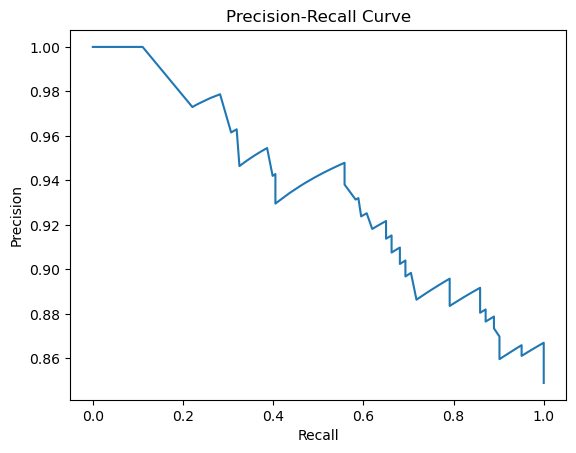

In [28]:
#precision-recall curve
import numpy as np

# Extracting probabilities and labels from PySpark DataFrame
probs = np.array(results_rf.select("pred").collect())
labels = np.array(results_rf.select("label").collect())

# Extracting predicted probabilities for positive class
positive_probs = probs[:,:,1]

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(labels, positive_probs)

import matplotlib.pyplot as plt

# Plotting the precision-recall curve
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

## Gradient-Boosted Tree

In [29]:
#tuning of hyperparameters Gradient-Boosted Tree
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
paramGrid = ParamGridBuilder() \
    .addGrid(word2vec.vectorSize, [2,3,4,5,6,7]) \
    .addGrid(gbt.maxDepth, [4,5,6,7]) \
    .build()

tvs_gbt = TrainValidationSplit(estimator=pipeline_gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
model_gbt = tvs_gbt.fit(train)

In [30]:
#Calculate area under Precision-Recall curve
results_gbt = model_gbt.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol ="pred", metricName="areaUnderPR")

aupr_gbt = evaluator.evaluate(results_gbt)
print("AUPRC: ",aupr_gbt)

AUPRC:  0.9071359657041874


In [31]:
#Best Model Parameters
best_model = model_gbt.bestModel
best_word2vec_param = best_model.stages[5].extractParamMap().get(word2vec.vectorSize)
best_gbt_treedepth = best_model.stages[9].extractParamMap().get(gbt.maxDepth)

print("Best word2vec dimension: ", best_word2vec_param )
print("Best max tree depth", best_gbt_treedepth)

Best word2vec dimension:  4
Best max tree depth 5


In [32]:
# binary classification metrics
results_gbt = model_gbt.bestModel.transform(test)
predvslabel = results_gbt.select("prediction", "label")
predvslabel = predvslabel.rdd.map(lambda row: (float(row["prediction"]), row["label"]))


threshold = 0.5
tp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 1.0).count()
tn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 0.0).count()
fp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 0.0).count()
fn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 1.0).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
tnrate = tn / (tn + fp)
fprate = fp / (fp + tn)
accuracy = (tp + tn) / ( tp + fp + tn + fn)

print("Precision at threshold {}: {}".format(threshold, precision))
print("Recall at threshold {}: {}".format(threshold, recall))
print("True Negative rate at threshold {}: {}".format(threshold, tnrate))
print("Number of False Positives at threshold {}: {}".format(threshold, fp))
print("Accuracy at threshold {}: {}".format(threshold, accuracy))

Precision at threshold 0.5: 0.8795180722891566
Recall at threshold 0.5: 0.8957055214723927
True Negative rate at threshold 0.5: 0.3103448275862069
Number of False Positives at threshold 0.5: 20
Accuracy at threshold 0.5: 0.8072916666666666


## Multi-Layer Perceptron

In [20]:
#tuning of hyperparameters multi-layer perceptron
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
layers1 = [8,2]
layers2 = [8,5,2]
layers3 = [8,8,2]
layers4 = [8,8,5,2]

paramGrid = ParamGridBuilder() \
    .addGrid(word2vec.vectorSize, [7]) \
    .addGrid(mlp.layers, [layers1,layers2,layers3,layers4]) \
    .build()

tvs_mlp = TrainValidationSplit(estimator=pipeline_mlp,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
model_mlp = tvs_mlp.fit(train)

In [21]:
#Calculate area under Precision-Recall curve
results_mlp = model_mlp.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol ="rawPrediction", metricName="areaUnderPR")

aupr_mlp = evaluator.evaluate(results_mlp)
print("AUPRC: ",aupr_mlp)

AUPRC:  0.18414778002393095


In [15]:
#Best Model Parameters
best_model = model_mlp.bestModel
best_layers = best_model.stages[9].extractParamMap().get(mlp.layers)

print("Best layer configuration ", best_layers)

Best layer configuration  [100, 50, 2]


In [16]:
# binary classification metrics
results_mlp = model_mlp.bestModel.transform(test)
predvslabel = results_mlp.select("prediction", "label")
predvslabel = predvslabel.rdd.map(lambda row: (float(row["prediction"]), row["label"]))


threshold = 0.5
tp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 1.0).count()
tn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 0.0).count()
fp = predvslabel.filter(lambda x: x[0] >= threshold and x[1] == 0.0).count()
fn = predvslabel.filter(lambda x: x[0] < threshold and x[1] == 1.0).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
tnrate = tn / (tn + fp)
fprate = fp / (fp + tn)
accuracy = (tp + tn) / ( tp + fp + tn + fn)

print("Precision at threshold {}: {}".format(threshold, precision))
print("Recall at threshold {}: {}".format(threshold, recall))
print("True Negative rate at threshold {}: {}".format(threshold, tnrate))
print("Number of False Positives at threshold {}: {}".format(threshold, fp))
print("Accuracy at threshold {}: {}".format(threshold, accuracy))

Precision at threshold 0.5: 0.8449197860962567
Recall at threshold 0.5: 0.9693251533742331
True Negative rate at threshold 0.5: 0.0
Number of False Positives at threshold 0.5: 29
Accuracy at threshold 0.5: 0.8229166666666666


# Final Model

#### Results


##### Logistic Regression
AUPRC:  0.8819122209694511

Precision at threshold 0.2957101129327625: 0.8534031413612565\
Recall at threshold 0.2957101129327625: 1.0\
True Negative rate at threshold 0.2957101129327625: 0.034482758620689655\
Number of False Positives 0.2957101129327625: 28\
Accuracy at threshold 0.2957101129327625: 0.8541666666666666
##### Decision Tree
AUPRC:  0.8924927285797553

Precision at threshold 0.5: 0.8466666666666667\
Recall at threshold 0.5: 0.7791411042944786\
True Negative rate at threshold 0.5: 0.20689655172413793\
Number of False Positives at threshold 0.5: 23\
Accuracy at threshold 0.5: 0.6927083333333334
##### Random Forest
AUPRC:  0.9347304465979542

Precision at threshold 0.6599788434082428: 0.864406779661017\
Recall at threshold 0.6599788434082428: 0.9386503067484663\
True Negative rate at threshold 0.6599788434082428: 0.1724137931034483\
Number of False Positives at threshold 0.6599788434082428: 24\
Accuracy at threshold 0.6599788434082428: 0.8229166666666666
##### Gradient-Booosted Tree
AUPRC:  0.9071359657041874

Precision at threshold 0.5: 0.8795180722891566\
Recall at threshold 0.5: 0.8957055214723927\
True Negative rate at threshold 0.5: 0.3103448275862069\
Number of False Positives at threshold 0.5: 20\
Accuracy at threshold 0.5: 0.8072916666666666
##### Multi-Layer  Perceptron
AUPRC:  0.8359012114886114

Precision at threshold 0.5: 0.8489583333333334\
Recall at threshold 0.5: 1.0\
True Negative rate at threshold 0.5: 0.0\
Number of False Positives at threshold 0.5: 29\
Accuracy at threshold 0.5: 0.8489583333333334

In [38]:
#Final estimator : gbt, best true-negative rate and good precision/recall

word2vec = Word2Vec(vectorSize=4, minCount=0, inputCol="filtered_words", outputCol="vectors")

gbt = GBTClassifier(labelCol="label", featuresCol="features", seed=1234)
gbt = gbt.setMaxIter(20)
gbt = gbt.setProbabilityCol("pred")
gbt = gbt.setMaxDepth(4)

pipeline_gbt = Pipeline(stages=[un_newline_inator,un_junk_inator,tokenizer,remover,
                               length_inator,word2vec,assembler,strindex,
                               final_features_inator, gbt])

final_model = pipeline_gbt.fit(df_small)

In [39]:
results_final = final_model.transform(df)

In [40]:
#save model
final_model.save(r"C:\Users\jef-w\Desktop\Uni\KUL\Year_1\Advanced_Analytics\Assignments\Assignment_3\spark\notebooks\GBT_Model")